# Algorithmic Trading Project
## Francisco Perestrello | 20241560

In [3]:
#!pip install backtrader

In [650]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt

from statsmodels.tsa.stattools import coint, adfuller
from scipy.stats import linregress

%matplotlib inline

## 1. Choose a trading strategy and describe its rational

**Strategy:** Moving Average Convergence Divergence (MACD) + Average True Range (ATR) + On-Balance Volume (OBV)

The strategy combines different indicators to create a Trend/Momentum - Volatility - Volume Combo

MACD - Momentum indicator that shows the relationship between two moving averages of an asset's price to identify trends

ATR - Volatility indicator that measures the average range of an asset's price movement over a specified period.

OBV - Volume indicator that uses volume flow to predict changes in stock price

**Rationale:**
MACD identifies momentum and trend shifts, offering sensitivity to shorter-term changes.
ATR provides volatility-adjusted risk management, tailoring stop and target prices to market conditions.
OBV ensures volume confirms the momentum, reducing the risk of entering on weak signals.

**Indicators:**

**1. MACD**
 - Fast EMA: 12
 - Slow EMA: 26
 - Signal Line: 9

**2. ATR**
 - Period: 14

**3. OBV**
 - Tracks volume trend for confirmation.

**Trading Rules:**
**Buy Signal:**
 - MACD Line crosses above the Signal Line (bullish momentum) and;
 - OBV is increasing over the last 3 periods (volume confirms the move).

**Sell Signal:**
 - MACD Line crosses below the Signal Line (bearish momentum) and;
 - OBV is decreasing over the last 3 periods (volume confirms the move).

**Position Sizing:** Risk-based (e.g., risk 1% of capital, position size = 1% / ATR).

**Stop Loss:** Entry price - (2 * ATR) for buys; Entry price + (2 * ATR) for sells.

**Take Profit:** Entry price + (4 * ATR) for buys; Entry price - (4 * ATR) for sells.


The indicators used are traditionally calculated using Close prices, so we will keep this approach. In case of liquidity concerns, one could use Open prices instead, although risking capturing noise due to gaps caused by overnight events.

## 2. Fetch data for a period greater than 5 years for the asset or assets you intend to test

In [5]:
# Single asset data
def get_data(ticker="NVDA", start="2010-01-01", end="2024-12-31"):
    data = yf.download(ticker, start=start, end=end, multi_level_index=False)
    data.columns = [col.lower() for col in data.columns]
    return data

asset = get_data("NVDA")
asset.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,close,high,low,open,volume
Date,,,,,
2010-01-04,0.423884,0.426864,0.415172,0.424342,800204000
2010-01-05,0.430073,0.434658,0.422279,0.422279,728648000
2010-01-06,0.432824,0.433741,0.425718,0.429844,649168000
2010-01-07,0.424342,0.432366,0.421133,0.430532,547792000
2010-01-08,0.425259,0.428239,0.418382,0.420903,478168000


## 3. Write clear trading rules to generate signals for your trades. This must include all detail generate an order (side, price, size, etc)

I was having some difficulties implementing the ta.volume.OnBalanceVolumeIndicator inside the Backtrader strategy, so I decided to manually create the indicator

### OBV Indicator Setup

In [6]:
class OnBalanceVolume(bt.Indicator):
    lines = ('obv',)

    def next(self):
        if len(self) == 1:  # First data point, initialize OBV
            self.lines.obv[0] = 0

        else:
            if self.data.close[0] > self.data.close[-1]:  # If the closing price is above the prior close price
                  self.lines.obv[0] = (self.lines.obv[-1] + self.data.volume[0])  # Then: Current OBV = Previous OBV + Current Volume
            elif self.data.close[0] < self.data.close[-1]:  # If the closing price is below the prior close price
                  self.lines.obv[0] = (self.lines.obv[-1] - self.data.volume[0])  # Then: Current OBV = Previous OBV - Current Volume
            else:
                  self.lines.obv[0] = self.lines.obv[-1] # If the closing price remains the same, Current OBV = Previous OBV

### Strategy Setup

In [7]:
class MACD_ATR_OBV_Strategy(bt.Strategy):
    params = (
        ('macd1', 12), ('macd2', 26), ('macdsig', 9),  # MACD params
        ('atr_period', 14),                            # ATR period
        ('risk_per_trade', 0.01),                      # 1% risk per trade
        ('obv_lookback', 3),                           # OBV lookback period
        ('stop_multiplier', 2),                        # Multiplier for stop loss
        ('target_multiplier', 4),                      # Multiplier for take profit
    )

    def __init__(self):
        # Indicators
        self.macd = bt.indicators.MACD(
            self.data.close, period_me1=self.p.macd1,
            period_me2=self.p.macd2, period_signal=self.p.macdsig
        )
        self.atr = bt.indicators.ATR(period=self.p.atr_period)
        self.obv = OnBalanceVolume(self.data)

        # Track OBV history for trend
        self.obv_history = []

        # Initialize stop and target prices
        self.stop_price = -float('inf')  # Default to negative infinity
        self.target_price = float('inf')  # Default to positive infinity

        # Track pending orders
        self.order = None

    def next(self):
        # If we have a pending order, skip this day
        if self.order:
            return

        # Update OBV history
        self.obv_history.append(self.obv[0])
        if len(self.obv_history) > self.p.obv_lookback:
            self.obv_history.pop(0) # Keep only the n latest observations (default 3)

        # Check if we have enough data
        if not self.macd.macd or len(self.obv_history) < self.p.obv_lookback:
            return

        # Signals
        MACD_uptrend = (self.macd.macd[0] > self.macd.signal[0] and self.macd.macd[-1] <= self.macd.signal[-1])  # MACD crosses signal line from below
        MACD_downtrend = (self.macd.macd[0] < self.macd.signal[0] and self.macd.macd[-1] >= self.macd.signal[-1])  # MACD crosses signal line from above

        OBV_rising = all(self.obv_history[i] < self.obv_history[i+1] for i in range(len(self.obv_history)-1))  # OBV rising
        OBV_falling = all(self.obv_history[i] > self.obv_history[i+1] for i in range(len(self.obv_history)-1))  # OBV falling

        exit_conditions = (self.data.close[0] <= self.stop_price or self.data.close[0] >= self.target_price)  # Price < stop_price or Price > target_price

        # Position sizing based on ATR
        cash = self.broker.getcash()   # Current available cash from the broker
        risk = cash * self.p.risk_per_trade  # Dollar amount to risk per trade
        atr_value = self.atr[0]  # Get current ATR value (high value signals high volatility)
        size = int(risk / atr_value)  # Calculate position size as the number of units to trade

        # Buy Logic
        if not self.position:
            if MACD_uptrend and OBV_rising:
                self.order = self.buy(size=size)
                self.stop_price = self.data.close[0] - self.p.stop_multiplier * atr_value        # Multiplier defaults to 2
                self.target_price = self.data.close[0] + self.p.target_multiplier * atr_value    # Multiplier defaults to 4

        # Sell Logic
            elif MACD_downtrend and OBV_falling:
                self.order = self.sell(size=size)
                self.stop_price = self.data.close[0] + self.p.stop_multiplier * atr_value
                self.target_price = self.data.close[0] - self.p.target_multiplier * atr_value

        # Exit conditions
        else:
            if exit_conditions:
                self.close()

    # Reset self.order flag when an order is complete
    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.order = None

## 4. Choose and describe at least 3 performance measures used in the backtesting analysis with a short description of the results

In addition to the built-in Backtrader analyzers, I will manually build a volatility analyzer so we can return this figure.

### Custom Volatility Analyzer

In [8]:
class Volatility(bt.Analyzer):
    params = (
        ('annualize', True),  # Whether to annualize volatility
        ('timeframe', 252),  # Timeframe for returns: daily 252, weekly 52, monthly 12, yearly 1
    )

    def __init__(self):
        self.returns = []  # Store returns
        self.volatility = None
        self.annualized_volatility = None
        self.prev_value = None

    def next(self):
        # Calculate current portfolio value
        portfolio_value = self.strategy.broker.getvalue()

        # Calculate return if we have a previous value
        if self.prev_value is not None and self.prev_value != 0:  # Avoid division by zero
            daily_return = np.log(portfolio_value / self.prev_value)  # Log Return, consistently with Backtrader Returns analyzer
            self.returns.append(daily_return)

        # Store current value for next iteration
        self.prev_value = portfolio_value

    def stop(self):
        # Calculate volatility
        self.volatility = np.std(self.returns)  # Daily volatility

        # Annualizing
        if self.p.annualize:
            scaling_factor = np.sqrt(self.p.timeframe)
            self.annualized_volatility = self.volatility * scaling_factor
        else:
            self.annualized_volatility = self.volatility  # Non-annualized

    def get_analysis(self):
        return {
            'vol': self.volatility,  # Raw volatility
            'ann_vol': self.annualized_volatility  # Annualized volatility
        }

### Backtest

Initial Portfolio Value:      100,000.00
Final Portfolio Value:        197,071.51
Total Compound Return: 67.84%
Annualized Compound Return: 4.64%
Average Daily Return: 0.02%
Annualized Volatility: 6.83%
Sharpe Ratio: 0.70
Max Drawdown: 12.17%


,amount,price,sid,symbol,value
2010-04-15,85845,0.411275,0,,-35305.883707
2010-04-22,-85845,0.374366,0,,32137.418362
2010-05-28,56362,0.309029,0,,-17417.505844
2010-06-08,-56362,0.262492,0,,14794.547949
2010-06-09,-61719,0.257677,0,,15903.591861
...,...,...,...,...,...
2024-06-25,-348,121.170135,0,,42167.206940
2024-06-26,348,126.098921,0,,-43882.424365
2024-08-14,253,118.500797,0,,-29980.701650
2024-11-08,-253,148.746063,0,,37632.753908


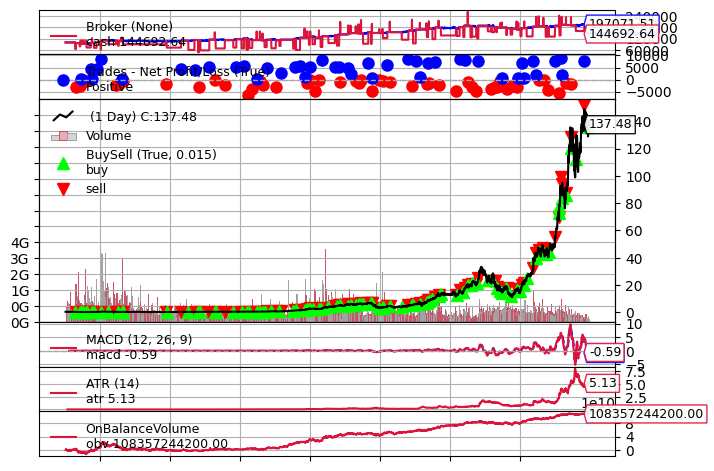

In [9]:
def run_backtest(
        data,
        strategy,
        cash=100_000,
        commission=0.0,
        plot=True,
        numfigs=1
    ):

    # Initialize the backtest
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(strategy)

    # Broker setup
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns', tann=252) # Annualize using 252 periods (daily data)
    cerebro.addanalyzer(Volatility, _name='volatility', annualize=True, timeframe=252)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0, annualize=True, timeframe=bt.TimeFrame.Days) # Specifying annualization timeframe
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Transactions)

    # Run backtest
    results = cerebro.run()

    # Print results
    strat = results[0]
    print('==================================================')
    print(f'Initial Portfolio Value: {strat.broker.startingcash:>15,.2f}')
    print(f'Final Portfolio Value:   {strat.broker.getvalue():>15,.2f}')
    print('==================================================')
    print(f'Total Compound Return: {strat.analyzers.returns.get_analysis()["rtot"]:.2%}')
    print(f'Annualized Compound Return: {strat.analyzers.returns.get_analysis()["rnorm"]:.2%}')
    print(f'Average Daily Return: {strat.analyzers.returns.get_analysis()["ravg"]:.2%}')
    print(f'Annualized Volatility: {strat.analyzers.volatility.get_analysis()["ann_vol"]:.2%}')
    print('==================================================')
    print(f'Sharpe Ratio: {strat.analyzers.sharpe.get_analysis()["sharperatio"]:.2f}')
    print(f'Max Drawdown: {strat.analyzers.drawdown.get_analysis()["max"]["drawdown"]:.2f}%')

    trades =  strat.analyzers.transactions.get_analysis()
    columns = ['amount', 'price', 'sid', 'symbol', 'value']
    trades = pd.DataFrame([row[0] for row in trades.values()], index=trades.keys(), columns=columns)
    display(trades)

    # Plot the backtest
    if plot:
        cerebro.plot(iplot=False, numfigs=numfigs, figsize=(5, 5))

# Get data
data = bt.feeds.PandasData(dataname=asset)

# Run strategy backtest
run_backtest(data, MACD_ATR_OBV_Strategy)

**Total Compound Return (67.84%):** This measure captures the total percentage increase in the portfolio value from the start to the end of the backtesting period, calculated using logarithmic returns to account for compounding. It reflects the overall profitability without considering time or risk.

**Annualized Compound Return (4.64%):** This represents the average annual growth rate of the portfolio, adjusted for compounding, over the backtesting period. It provides a standardized view of returns, assuming consistent performance each year.

**Annualized Volatility (6.83%):** Measures the annualized standard deviation of daily returns

**Sharpe Ratio (0.70):** The Sharpe Ratio measures risk-adjusted returns. It shows how much return is earned per unit of risk (volatility), with a higher ratio indicating better efficiency.

**Max Drawdown (12.17%):** Max Drawdown indicates the largest percentage decline in portfolio value from a previous peak. It highlights the worst-case loss an investor might face, emphasizing the strategy’s risk exposure.

**Results**

Increasing the portfolio value from 100,000.00 to 197,071.35, the strategy achieved a Total Compound Return of 67.84% and an Annualized Compound Return of 4.64% which, given our 15 year timeframe, are not outstanding results. An Annualized Volatility of 6.83% shows the strategy's low-risk profile, and a Sharpe Ratio of 0.70 indicates moderate risk-adjusted performance. With a Max Drawdown of 12.17%, the strategy effectively limited losses, reflecting solid risk management.

**Note:**
The SharpeRatio Backtrader analyzer uses the arithmetic mean return, which is different than the geometric mean return (log returns) from the Returns and Volatility analyzers, hence the difference between the value presented and the manual calculation from the annualized return and volatility.
The geometric return accounts for compounding, making it lower for volatile strategies, while the arithmetic return is commonly used in the Sharpe Ratio to reflect expected returns.

## 5. Optimize and backtest your chosen strategy, leaving at least one full year out of the training data to test the strategy out of sample. Describe the target variable used to optimize and justify your choice

In [10]:
# Splitting the data
X_train = asset.loc["2010-01-01":"2022-12-31"]  # Training: 2010–2022
X_test = asset.loc["2023-01-01":"2024-12-31"]  # Out-of-sample: 2023–2024

X_train = bt.feeds.PandasData(dataname=X_train)
X_test = bt.feeds.PandasData(dataname=X_test)

In [11]:
def optimize_strategy(
    X_train,
    cash=100_000,
    commission=0.0
    ):

    # Initialize backtest
    cerebro = bt.Cerebro(optreturn=False)  # Optimize without returning full results
    cerebro.adddata(X_train)

    # Broker setup
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns', tann=252) # Annualize using 252 periods (daily data)
    cerebro.addanalyzer(Volatility, _name='volatility', annualize=True, timeframe=252)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0, annualize=True, timeframe=bt.TimeFrame.Days) # Specifying annualization timeframe
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Define parameter ranges
    cerebro.optstrategy(
        MACD_ATR_OBV_Strategy,
        macd1=[10, 12, 14],
        macd2=[21, 26, 30],
        macdsig=[7, 9, 11],
        risk_per_trade=[0.01, 0.05, 0.1],
        obv_lookback=[3, 5],
        stop_multiplier=[1.5, 2, 2.5],
        target_multiplier=[3, 4, 5]
    )

    # Run optimization
    results = cerebro.run()

    # Find best parameters
    best_sharpe = -float('inf')  # Target variable to optimize
    best_params = None
    for run in results:
        for strat in run:
            sharpe = strat.analyzers.sharpe.get_analysis()["sharperatio"]
            if sharpe is None:  # Invalid runs
              sharpe = -float('inf')
            elif sharpe > best_sharpe:  # Better Sharpe Ratio achieved
                best_sharpe = sharpe  # Store the best sharpe
                best_params = strat.params.__dict__  # Store the best parameters

    # Print results
    print(f"Best Sharpe Ratio: {best_sharpe:.2f}")
    print(f"Best Parameters: {best_params}")
    return best_params

# Run optimization
best_params = optimize_strategy(X_train, cash=100_000, commission=0.0)

Best Sharpe Ratio: 0.86
Best Parameters: {'macd1': 14, 'macd2': 21, 'macdsig': 11, 'atr_period': 14, 'risk_per_trade': 0.01, 'obv_lookback': 3, 'stop_multiplier': 2, 'target_multiplier': 5}


The Sharpe Ratio, which quantifies the excess return per unit of risk (set-up with a risk-free rate of 0%), was chosen as the target variable to optimize. There are many reasons why this aligns with the strategy proposed, mainly the strategy's risk-adjusted focus and the performance measure's robustness and comparability.

The Sharpe Ratio balances profitability and risk, which is crucial for a strategy using ATR for position sizing and stop-losses, as it aligns with the goal of controlled risk exposure. Then, maximizing Sharpe discourages overfitting to high-return but volatile parameters, ensuring stability across market conditions. Finally, it’s a standard metric for evaluating trading strategies, allowing comparison with benchmarks or other strategies, unlike raw returns which ignore risk.

## 6. What would have been the P/L and the risk measures of the strategy during the backtest and out of sample? Comment the results

In-Sample Backtest (2010–2022):
Initial Portfolio Value:      100,000.00
Final Portfolio Value:        236,290.21
Total Compound Return: 85.99%
Annualized Compound Return: 6.85%
Average Daily Return: 0.03%
Annualized Volatility: 7.99%
Sharpe Ratio: 0.86
Max Drawdown: 10.61%


,amount,price,sid,symbol,value
2010-04-05,-79648,0.397291,0,,31643.400029
2010-04-06,79648,0.395686,0,,-31515.588792
2010-04-15,85955,0.411275,0,,-35351.123933
2010-04-22,-85955,0.374366,0,,32178.598583
2010-05-28,56434,0.309029,0,,-17439.755949
...,...,...,...,...,...
2022-12-01,3560,16.985085,0,,-60466.903441
2022-12-07,-3377,15.759086,0,,53218.434768
2022-12-08,3377,16.259677,0,,-54908.929769
2022-12-14,3138,17.972272,0,,-56396.990104


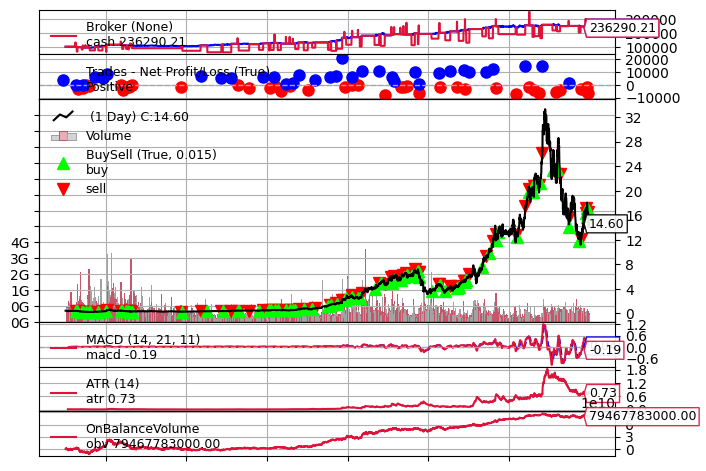

In [12]:
# Update strategy with best parameters
class OptimizedStrategy(MACD_ATR_OBV_Strategy):
    params = best_params

# In-sample backtest
print("In-Sample Backtest (2010–2022):")
run_backtest(X_train, OptimizedStrategy)

The MACD_ATR_OBV_Strategy performed robustly in both in-sample and out-of-sample periods, demonstrating profitability and effective risk management, though with differences in scale and efficiency.

In the in-sample period (2010–2022), the strategy achieved a substantial Total Compound Return of 85.99%, growing the portfolio to 236,290.21 over 13 years, with an Annualized Compound Return of 6.85%. This strong performance was accompanied by a moderate Annualized Volatility of 7.99% and a Max Drawdown of 10.61%, indicating stable returns and limited downside risk. The Sharpe Ratio of 0.86 reflects good risk-adjusted performance, suggesting the strategy effectively balanced returns against volatility during NVDA’s growth phase.

Out-of-Sample Backtest (2023–2024):
Initial Portfolio Value:      100,000.00
Final Portfolio Value:        118,773.86
Total Compound Return: 17.21%
Annualized Compound Return: 9.04%
Average Daily Return: 0.03%
Annualized Volatility: 6.04%
Sharpe Ratio: 1.47
Max Drawdown: 3.80%


,amount,price,sid,symbol,value
2023-03-20,976,25.598375,0,,-24984.014270
2023-05-19,-976,31.515529,0,,30759.155862
2023-06-26,-722,42.437830,0,,30640.112909
2023-06-27,722,40.776737,0,,-29440.804421
2023-07-24,-686,44.706592,0,,30668.722441
2023-07-25,686,44.916483,0,,-30812.707414
2023-09-11,-583,46.126622,0,,26891.820659
2023-09-12,583,44.717270,0,,-26070.168424
2023-10-19,-663,42.791167,0,,28370.543952
2023-10-20,663,41.870590,0,,-27760.201067


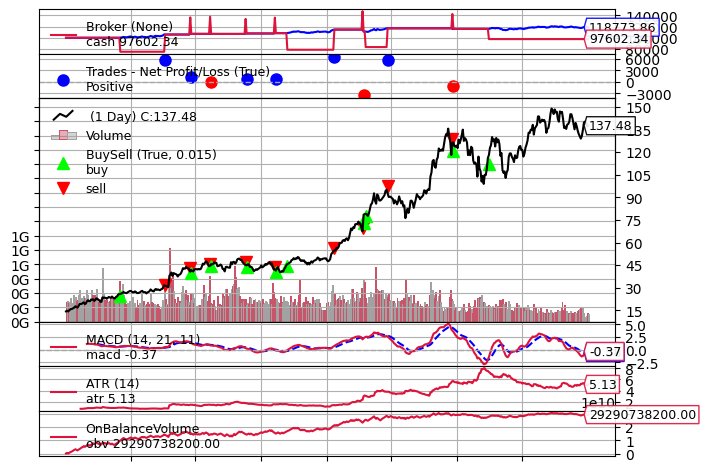

In [13]:
# Out-of-sample backtest
print("Out-of-Sample Backtest (2023–2024):")
run_backtest(X_test, OptimizedStrategy)

In the out-of-sample period (2023–2024), the strategy remained profitable, yielding a Total Compound Return of 17.21% and a Final Portfolio Value of 118,773.86 over 2 years. The Annualized Compound Return of 9.04% was higher than in-sample, reflecting stronger per-year performance in a shorter, potentially more volatile period. The Sharpe Ratio improved to 1.47, indicating better risk-adjusted returns, due to the strategy capitalizing on NVDA’s recent trends with higher efficiency. Notably, the Max Drawdown dropped to 3.80%, showcasing exceptional risk control, with even Annualized Volatility decreasing to 6.04%.

Comparing the periods, the out-of-sample performance demonstrates the strategy’s robustness, as it maintained profitability and improved risk-adjusted returns despite a shorter timeframe. The lower Max Drawdown out-of-sample suggests the strategy adapted well to recent market conditions, possibly due to effective ATR-based stop-losses and position sizing. However, the shorter period mean the Total Compound Return is lower than in-sample, which is expected given the longer in-sample horizon. Overall, the results validate the strategy’s ability to generalize to unseen data, with the improved Sharpe Ratio and reduced drawdown highlighting its resilience and suitability for trading NVDA.

### Assessing the impact of commissions

Out-of-Sample Backtest (2023–2024) (0.01% commission):
Initial Portfolio Value:      100,000.00
Final Portfolio Value:        112,955.69
Total Compound Return: 12.18%
Annualized Compound Return: 6.32%
Average Daily Return: 0.02%
Annualized Volatility: 6.14%
Sharpe Ratio: 1.03
Max Drawdown: 4.42%


,amount,price,sid,symbol,value
2023-03-20,976,25.598375,0,,-24984.014270
2023-05-19,-976,31.515529,0,,30759.155862
2023-06-26,-718,42.437830,0,,30470.361591
2023-06-27,718,40.776737,0,,-29277.697471
2023-07-24,-679,44.706592,0,,30355.776294
2023-07-25,679,44.916483,0,,-30498.292032
2023-09-11,-573,46.126622,0,,26430.554439
2023-09-12,573,44.717270,0,,-25622.995723
2023-10-19,-649,42.791167,0,,27771.467609
2023-10-20,649,41.870590,0,,-27174.012809


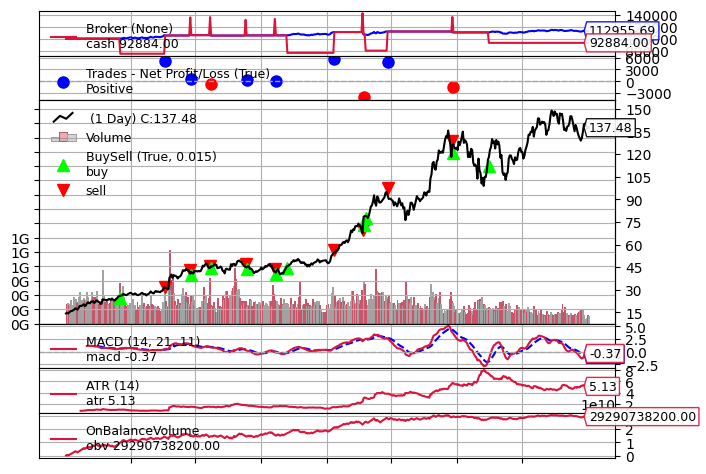

In [14]:
# Out-of-sample backtest
print("Out-of-Sample Backtest (2023–2024) (0.01% commission):")
run_backtest(X_test, OptimizedStrategy, commission=0.01)  # 0.01%

Having traded few times in the two-year period, the added broker commission did not take a large effect on the strategy, with it remaining profitable with an Annualized Compound Return of 6.32% and a Sharpe Ratio above 1 out-of-sample.

## 7. Choose two assets to build a pairs trading strategy. Perform an initial analysis to verify if the two assets are appropriate to be traded in this strategy and backtest your strategy explaining your assumptions and results.

### Finding Pairs

Combining a top-down approach based on logical economic reasoning and a bottom-up approach checking every combination, I propose eight possible pairs that I imagine would make sense to trade together.
Then, I will be running an initial co-integration analysis to find optimal pairs for pair trading.

In [652]:
# List of tickers
tickers = ['WMT', 'TGT', 'MCD', 'YUM', 'BA', 'AIR.PA', 'T', 'VZ', 'JNJ', 'MRK', 'GLD', 'SLV', 'NKE', 'ADDYY', 'EWJ', 'EWH']

# Download the data
data = yf.download(tickers, start='2010-01-01', end='2024-12-31', multi_level_index=False).Close.dropna() # auto_adjust=True (default): When this is set, yfinance automatically adjusts the historical prices to reflect splits and dividends
data.head()

[*********************100%***********************]  16 of 16 completed


Ticker,ADDYY,AIR.PA,BA,EWH,EWJ,GLD,JNJ,MCD,MRK,NKE,SLV,T,TGT,VZ,WMT,YUM
Date,,,,,,,,,,,,,,,,
2010-01-04,23.084341,11.286740,43.777565,10.073703,31.166365,109.800003,41.324886,41.265453,21.204031,13.509631,17.230000,6.965053,32.357162,14.213721,13.048595,18.789495
2010-01-05,23.708239,11.250434,45.211342,10.167789,31.353552,109.699997,40.845707,40.949940,21.289970,13.563385,17.510000,6.930934,32.477112,14.239347,12.918665,18.725237
2010-01-06,23.666647,11.351280,46.582802,10.199156,31.478344,111.510002,41.177948,40.391239,21.576437,13.480686,17.860001,6.862847,33.096958,13.829912,12.889789,18.591372
2010-01-07,23.791426,11.464229,48.468567,10.199156,31.197559,110.820000,40.884052,40.687023,21.610813,13.612997,17.889999,6.785793,33.503494,13.747588,12.897004,18.586012
2010-01-08,23.833017,11.577177,48.001007,10.205425,31.571922,111.370003,41.024601,40.647575,21.599360,13.586123,18.150000,6.736080,33.370201,13.756255,12.832038,18.591372


In [654]:
# Looking for cointegrated pairs
def cointegrated_pairs(data):
    n =  (len(data.columns))
    stocks = data.columns
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = []
    for i in range(0,n):
        for j in range(0,n):
            if i == j: continue
            S1 = data.values[:,i]
            S2 = data.values[:,j]
            result = coint(S1,S2)  # Calculate cointegration p-value for every combination of assets

            pvalue_matrix[i,j] = result[1]

    return pd.DataFrame(pvalue_matrix, columns=stocks, index=stocks)

result = cointegrated_pairs(data)

# Highlight p-values that reject non-cointegration for a 5% significance level
def highlight_cells(val):
    color = 'yellow' if 0.00001 < val < 0.05 else ''
    return 'background-color: {}'.format(color)

# Output the highlighted table
result.style.map(highlight_cells)

Ticker,ADDYY,AIR.PA,BA,EWH,EWJ,GLD,JNJ,MCD,MRK,NKE,SLV,T,TGT,VZ,WMT,YUM
Ticker,,,,,,,,,,,,,,,,
ADDYY,0.000000,0.639813,0.622648,0.262684,0.545001,0.778242,0.507293,0.702281,0.693471,0.745024,0.737880,0.563021,0.553376,0.068480,0.892552,0.733520
AIR.PA,0.811154,0.000000,0.978522,0.905531,0.099349,0.681125,0.299797,0.170061,0.088802,0.837264,0.891392,0.317376,0.658499,0.741493,0.191190,0.038187
BA,0.586049,0.935157,0.000000,0.278574,0.810119,0.651895,0.471333,0.734946,0.553808,0.673700,0.230435,0.669929,0.590817,0.311487,0.696785,0.772856
EWH,0.080259,0.538445,0.147874,0.000000,0.555366,0.534452,0.339706,0.542192,0.481592,0.118708,0.165035,0.688080,0.301600,0.020769,0.774205,0.626290
EWJ,0.680294,0.063640,0.931023,0.901837,0.000000,0.620368,0.047152,0.118634,0.168242,0.640712,0.873588,0.220610,0.352171,0.418796,0.525785,0.050785
GLD,0.976834,0.884277,0.981853,0.987824,0.865688,0.000000,0.955771,0.814984,0.853731,0.982405,0.993872,0.911606,0.956364,0.981291,0.314658,0.867183
JNJ,0.611360,0.235603,0.814710,0.737780,0.046343,0.811822,0.000000,0.495771,0.421396,0.259437,0.828747,0.492848,0.338690,0.527261,0.993936,0.228300
MCD,0.937662,0.217736,0.981588,0.969715,0.193823,0.706004,0.658981,0.000000,0.068615,0.979263,0.986715,0.659277,0.746833,0.937089,0.902973,0.002070
MRK,0.885359,0.090035,0.950181,0.933398,0.221343,0.642971,0.690308,0.069526,0.000000,0.894045,0.962618,0.661065,0.759327,0.917835,0.851123,0.031435


We can see the pair that more strongly rejects non-cointegration at a 5% significance level is YUM and MCD (Yum! Brands, who own KFC, Pizza Hut, Taco Bell, and Habit Burger & Grill, and McDonald's). This aligns with one of our initial proposals and makes sense that the two assets are connected given they operate on the same industry of fast food.

In [17]:
# Selected pair
tickers = ['YUM', 'MCD']
pair_data = data[tickers]
pair_data.head()

Ticker,YUM,MCD
Date,,
2010-01-04,18.789490,41.265442
2010-01-05,18.725231,40.949940
2010-01-06,18.591373,40.391232
2010-01-07,18.586018,40.687019
2010-01-08,18.591373,40.647579


### Correlation

In [18]:
correlation = pair_data.corr().iloc[0, 1]
print(f"Correlation between {tickers[0]} and {tickers[1]}: {correlation:.2f}")

Correlation between YUM and MCD: 0.99


A strong positive correlation is a good indication of movement between the pair. To confirm they move together, we can test for cointegration.

### Cointegration

In [19]:
def cointegration(a, b):
    if coint(a, b)[1] < 0.05:
        print('The series are cointegrated')
        print(f"Cointegration p-value: {coint(a, b)[1]:.4f}")
    else:
        print('The series are NOT cointegrated')
        print(f"Cointegration p-value: {coint(a, b)[1]:.4f}")

# Log prices
log_prices = np.log(pair_data)

asset_A = pair_data[tickers[0]]
asset_B = pair_data[tickers[1]]
asset_A_log = log_prices[tickers[0]]
asset_B_log = log_prices[tickers[1]]

# Run cointegration test
cointegration(asset_A, asset_B)

The series are cointegrated
Cointegration p-value: 0.0015


In [20]:
# Run cointegration test on log prices
cointegration(asset_A_log, asset_B_log)

The series are cointegrated
Cointegration p-value: 0.0112


In both forms we see confirmation that there is evidence to reject non-cointegration between YUM and MCD at a 5% significance level.

Log prices normalize price scales, stabilize variance, and align with the statistical assumptions of cointegration and stationarity tests, making them more robust for pairs with different price levels. As such, log prices will be used from here on.

### Stationarity

It is important to confirm the process generated between the two assets (both spread and/or ratio) is stationary, meaning the statistical properties of the time series do not change over time.

Usually it is enough to look at either, but for completeness sake I will explore both the spread and the ratio.

In [21]:
# Augmented Dickey Fuller test for stationarity
def dickey_fuller(x):
    stat, p, lags, obs, crit, t = adfuller(x)
    print(f"ADF p-value for spread stationarity: {p:.4f}")
    if p > 0.05:
        print('Probably NOT Stationary')
    else:
        print('Probably Stationary')

#### Spread

ADF p-value for spread stationarity: 0.0043
Probably Stationary


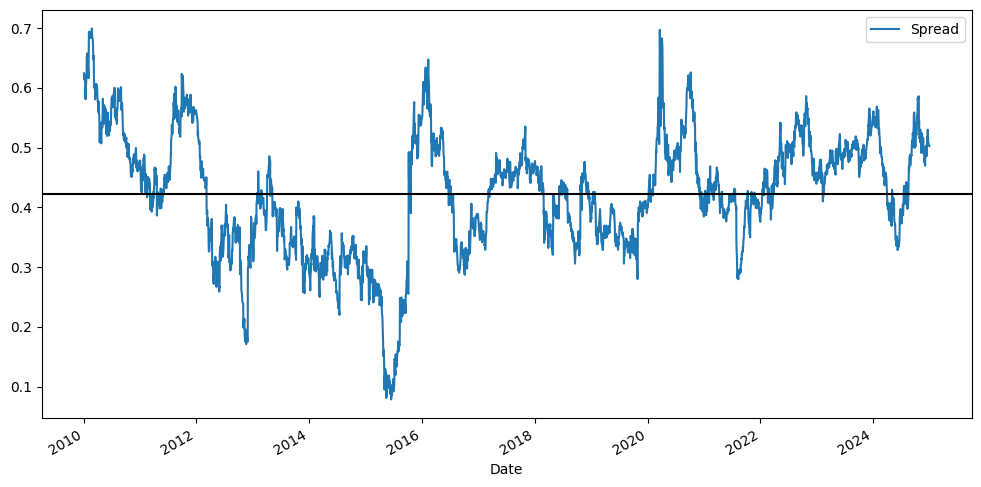

In [22]:
# Augmented Engle-Granger two-step method

# Regression
reg = linregress(asset_A_log, asset_B_log)

# Compute spread
spread = asset_B_log - reg.slope * asset_A_log

# ADF test for stationarity
dickey_fuller(spread)

# Plot
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

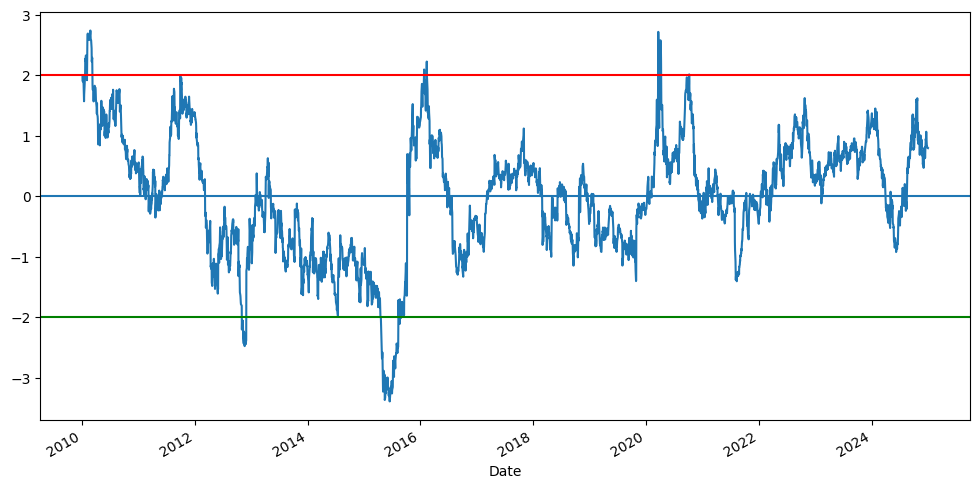

In [23]:
# Z-score function to standardize series
def zscore(series):
    return (series - series.mean()) / np.std(series)

n = 2

# Plot the standardized spread
zscore(spread).plot(figsize=(12,6))

plt.axhline(zscore(spread).mean())
plt.axhline(n, color='red')
plt.axhline(-n, color='green')
plt.show()

Indeed, the standardized spread visually confirms the statistical test that rejected non-stationarity, with the series not crossing two standard deviation distances many times over the entire 15 years, and when doing so quickly exhibiting some mean-reverting behaviour.

#### Ratio

ADF p-value for spread stationarity: 0.0215
Probably Stationary


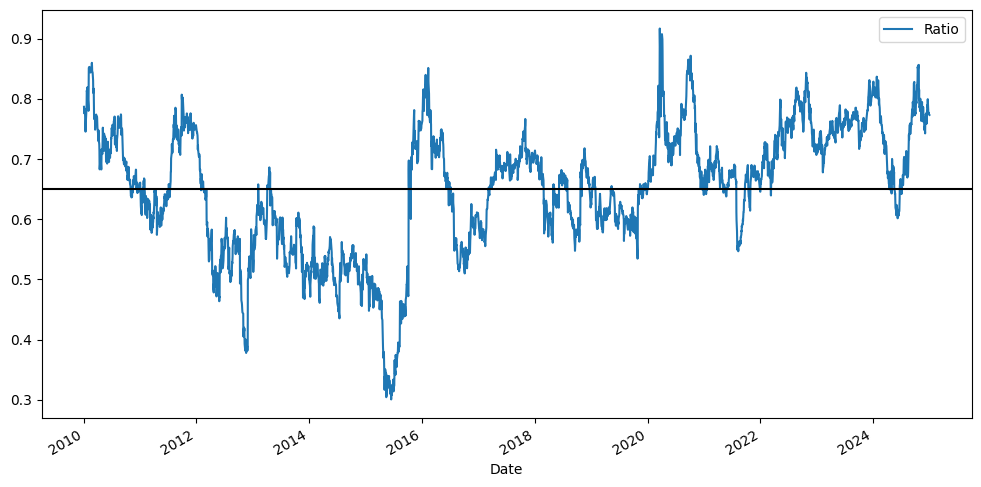

In [24]:
# Calculate the ratio
ratio = asset_B_log - asset_A_log  # asset_B / asset_A => log prices imply => log(asset_B) - log(asset_A)

# ADF test for stationarity
dickey_fuller(ratio)

# Plot
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.legend(['Ratio']);

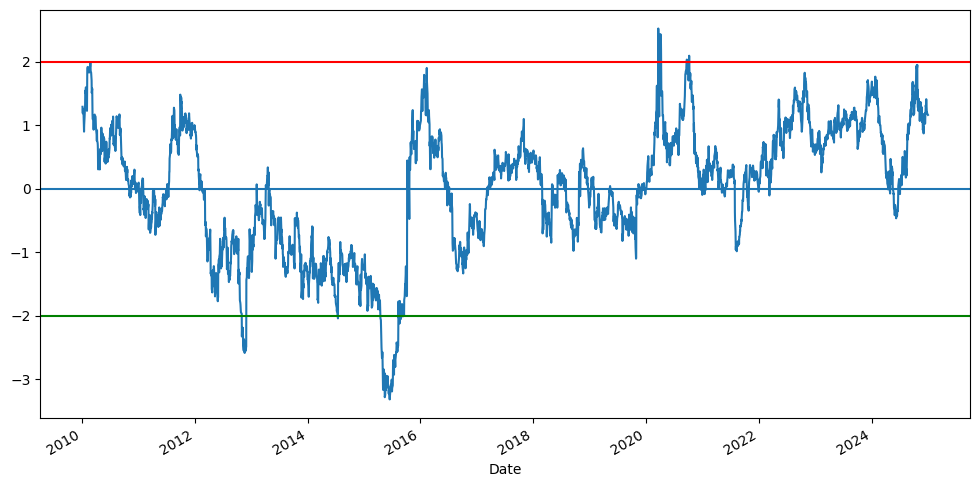

In [25]:
# Plot the standardized ratio
zscore(ratio).plot(figsize=(12,6))

plt.axhline(zscore(ratio).mean())
plt.axhline(n, color='red')
plt.axhline(-n, color='green')
plt.show()

Again, the standardized ratio visually confirms the statistical test that rejected non-stationarity, exhibiting some form of mean-reverting behaviour.

### Pair Trading Strategy

With the above confirmation of asset co-movement, the strategy builds upon the notion that the relative prices in a market are in equilibrium, and that deviations from this equilibrium will eventually be corrected.

When one stock outperforms the other, the outperformer is sold short and the other stock is bought long, with the expectation that the short-term diversion will end in convergenc The strategy also has arbitrary parameteres defining how far from the historical mean prices must be in order to enter trades (upper/lower), how close to full mean-reversion they must be in order to exit trades (up_medium, low_medium), as well as how long to consider for z-score computations (period), among others.e.

In [26]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=30,
        qty1=0,
        qty2=0,
        upper=2,
        lower=-2,
        up_medium=0.5,
        low_medium=-0.5,
        status=0,
        portfolio_value=100000,
    )

    # Step 1: Initialize
    def __init__(self):
        self.order = None  # Track pending orders
        self.qty1 = self.p.qty1
        self.qty2 = self.p.qty2
        self.upper_limit = self.p.upper  # Extreme positive deviation
        self.lower_limit = self.p.lower  # Extreme negative deviation
        self.up_medium = self.p.up_medium  # Mean-reversion confirmation from above
        self.low_medium = self.p.low_medium  # Mean-reversion confirmation from below
        self.status = self.p.status  # Whether we are long, short, or out of the market
        self.portfolio_value = self.p.portfolio_value

        # Signals performed with PD.OLS :
        self.transform = bt.indicators.OLS_TransformationN(self.data0, self.data1,
                                                   period=self.p.period, plot=True)
        self.zscore = self.transform.zscore

    def stop(self):
        print('==================================================')
        print(f'Starting Portfolio Value: {self.broker.startingcash:>15,.2f}')
        print(f'Final Portfolio Value:    {self.broker.getvalue():>15,.2f}')
        print('==================================================')

    def next(self):
        # If we have a pending order, skip this day
        if self.order:
            return

        # Step 2: Check conditions for SHORT & place the order
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):   # Extreme positive deviation & we aren't yet short

            # Calculating the number of shares for each stock
            value = 0.5 * self.broker.getvalue()  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2

            # Placing the order
            self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for selling x + qty1 shares
            self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for buying y + qty2 shares

            # Updating the quantity counters with new values
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            self.status = 1  # The current status is "short the spread"

        # Step 3: Check conditions for LONG & place the order
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):   # Extreme negative deviation & we aren't yet long

            # Calculating the number of shares for each stock
            value = 0.5 * self.broker.getvalue()  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2

            # Place the order
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares

            # Updating the quantity counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            self.status = 2  # The current status is "long the spread"

        # Step 4: Check conditions for No Trade -> If the z-score is within the two bounds, close all
        elif (self.zscore[0] < self.up_medium and self.zscore[0] > self.low_medium):  # Mean-reversion achieved
            self.close(self.data0)
            self.close(self.data1)
            self.status = 0  # Reset status to neutral

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['YUM', 'MCD']


Starting Portfolio Value:      100,000.00
Final Portfolio Value:         151,871.61
Total Compound Return: 41.79%
Annualized Compound Return: 2.83%
Average Daily Return: 0.01%
Annualized Volatility: 10.13%
Sharpe Ratio: 0.32
Max Drawdown: 23.27%


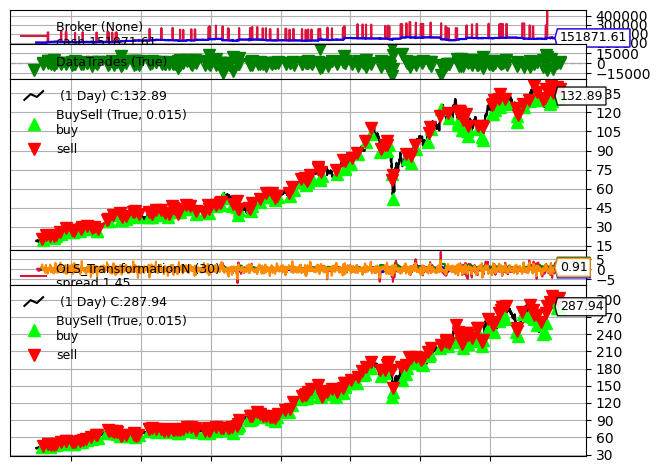

In [27]:
def runstrategy(tickers, start, end, cash=100_000, commperc=0.0, period=30, upper=2, lower=-2, up_medium=0.5, low_medium=-0.5, plot=True, numfigs=1):

    # Initialize the backtest
    cerebro = bt.Cerebro()

    # Get and feed the data for the two assets
    ticker_A, ticker_B = tickers
    data0 = bt.feeds.PandasData(dataname=yf.download(ticker_A, start, end, multi_level_index=False))
    cerebro.adddata(data0)
    data1 = bt.feeds.PandasData(dataname=yf.download(ticker_B, start, end, multi_level_index=False))
    cerebro.adddata(data1)

    # Add the strategy
    cerebro.addstrategy(PairTradingStrategy,
                        period=period,
                        upper=upper,
                        lower=lower,
                        up_medium=up_medium,
                        low_medium=low_medium)

    # Broker setup
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commperc)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns', tann=252) # Annualize using 252 periods (daily data)
    cerebro.addanalyzer(Volatility, _name='volatility', annualize=True, timeframe=252)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0, annualize=True, timeframe=bt.TimeFrame.Days) # Specifying annualization timeframe
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Run backtest
    results = cerebro.run()

    # Print results
    strat = results[0]
    print(f'Total Compound Return: {strat.analyzers.returns.get_analysis()["rtot"]:.2%}')
    print(f'Annualized Compound Return: {strat.analyzers.returns.get_analysis()["rnorm"]:.2%}')
    print(f'Average Daily Return: {strat.analyzers.returns.get_analysis()["ravg"]:.2%}')
    print(f'Annualized Volatility: {strat.analyzers.volatility.get_analysis()["ann_vol"]:.2%}')
    print('==================================================')
    print(f'Sharpe Ratio: {strat.analyzers.sharpe.get_analysis()["sharperatio"]:.2f}')
    print(f'Max Drawdown: {strat.analyzers.drawdown.get_analysis()["max"]["drawdown"]:.2f}%')

    # Plot the backtest
    if plot:
        cerebro.plot(iplot=False, numfigs=numfigs, volume=False, zdown=False)

# Run strategy backtest
print(tickers)
runstrategy(tickers, '2010-01-01', '2024-12-31', commperc=0.00, period=30)

The proposed strategy didn't show great results over the entire 15 year dataset. With just around 50,000 added to the portfolio value, the 41.79% Total Compound Return leads to an Annualized Compound Return of just 2.83%. With a moderate 10.13% volatility, the strategy seems to bear too much risk for the returns it is generating, achieving a low Sharpe Ratio of 0.32 and a moderate Max Drawdown of 23.37%.

### Assessing the impact of commissions

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value:      100,000.00
Final Portfolio Value:             957.79
Total Compound Return: -464.83%
Annualized Compound Return: -26.69%
Average Daily Return: -0.12%
Annualized Volatility: 13.29%
Sharpe Ratio: -2.29
Max Drawdown: 99.07%


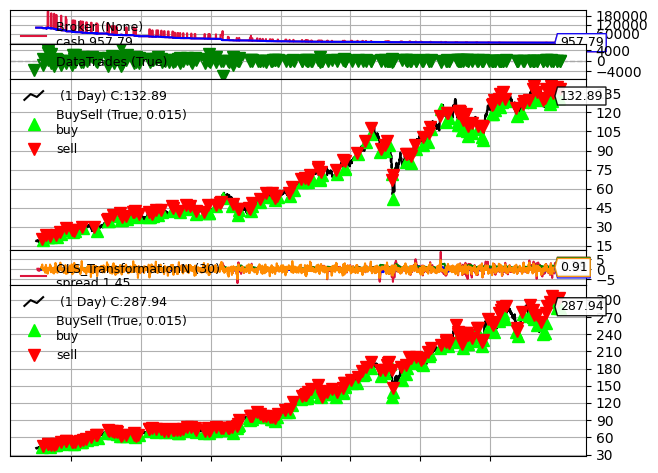

In [28]:
# Add commission
runstrategy(tickers, '2010-01-01', '2024-12-31', commperc=0.01, period=30)

The strong effect of commissions on the strategy performance clearly indicate the strategy trades too often, with a small 0.01% commission dropping the final portfolio value from 151,871.61 down to just 957.79 and severely worsening all metrics analyzed.

To reduce the number of trades, we could increase the upper and lower limits required for the strategy to enter the market, adjust the rolling period under which the Z-scores are calculated, or even make the exit condition harder to achieve by squishing the z-scores required to exit closer to 0.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value:      100,000.00
Final Portfolio Value:          34,056.33
Total Compound Return: -107.72%
Annualized Compound Return: -6.94%
Average Daily Return: -0.03%
Annualized Volatility: 8.95%
Sharpe Ratio: -0.76
Max Drawdown: 71.26%


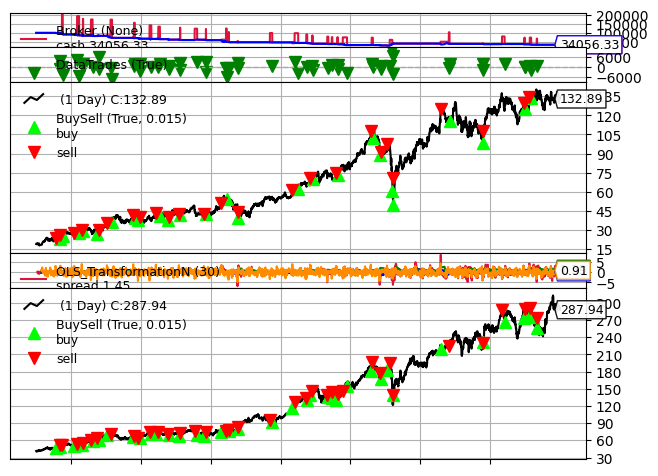

In [29]:
# Testing harder conditions to enter/exit the market
runstrategy(tickers, '2010-01-01', '2024-12-31', commperc=0.01, period=30, upper=3, lower=-3, up_medium=0.1, low_medium=-0.1)

Indeed, harder conditions lead to a lot fewer trades, thus drastically reducing the effect of the 0.01% commission. Nonetheless, it was insufficient to prevent the strategy from becoming unprofitable, with the final portfolio value after 15 years of trading ammounting to 34,056.33 and thus yielding a negative Sharpe Ratio.